In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
import seaborn as sns

### Load Diabetes data bunch from SciKit Learn and show keys

In [2]:
diabetes = datasets.load_diabetes()

print(diabetes.keys())

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])


### Construct a Pandas dataframe of the data and target

In [3]:
df = pd.DataFrame(diabetes['data'])
df.columns = diabetes['feature_names']

df['target'] = diabetes['target']

### Show features for diabetes dataframe

In [4]:
df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

# Construct Regressor with Single Predictor

In [5]:
feature_interest = 'bmi'

### Construct dataframe

In [6]:
df_1feature = df[[feature_interest, 'target']].copy()

In [7]:
df_1feature

,bmi,target
0,0.061696,151.0
1,-0.051474,75.0
2,0.044451,141.0
3,-0.011595,206.0
4,-0.036385,135.0
...,...,...
437,0.019662,178.0
438,-0.015906,104.0
439,-0.015906,132.0
440,0.039062,220.0


In [8]:
df_1feature.sort_values(by= feature_interest, inplace= True)

### Solve explicitly

In [9]:
def find_optimal_cutpoint(df_in):
    '''
    Calculates optimal split point for decission tree regression.
    Prints MSE for parent and children nodes to screen
    
    Input: 
        df_in: Dataframe with features and target values for node to be calculated      
    Output:
        optimal_feature: The feature that produces the minimum total cost at a node. 
        optimal_cut: For the optimal feature, the best split point from minimizing the total cost 
        left_val: After splitting on optimal cut, the average value of instances within left (less than) node
        right_val:  After splitting on optimal cut, the average value of instances within right (equal to, or greater than) node
        optimal_feature:
    '''
    
    optimal_by_feature = {}
    total_costs = {}
    for feat in list(df_in.columns.drop('target')):
        ## Sort values by feature
        temp_df = df_in[[feat, 'target']].sort_values(by= feat)
        
        cutpoints = []
        LT_MSEs = []
        GTE_MSEs = []
        
        feat_unique_values = np.sort(df_in[feat].unique())
        for i in np.arange(0, feat_unique_values.shape[0] - 1, 1):
            cutpoint = feat_unique_values[i:i+2].mean()
            cutpoints.append(cutpoint)

            LT = temp_df[temp_df[feat] < cutpoint]
            LT_MSEs.append(
                (LT.shape[0] / temp_df.shape[0]) * ((LT.target - LT.target.mean()) ** 2).mean()
            )

            GTE = temp_df[temp_df[feat] >= cutpoint]
            GTE_MSEs.append(
                (GTE.shape[0] / temp_df.shape[0]) * ((GTE.target - GTE.target.mean()) ** 2).mean()
            )

        total_cost = (np.array(LT_MSEs) + np.array(GTE_MSEs))
        total_cost = np.nan_to_num(total_cost, nan= total_cost[-1])
        

        optimal_by_feature[feat] = {'total_cost':total_cost[total_cost.argmin()], 
                                    'cutpoint':cutpoints[total_cost.argmin()]}
        
        total_costs[feat] = ({'data': pd.DataFrame({'cutpoint':cutpoints,
                                                    'total_cost':total_cost}),
                                          'opt_cutpoint':cutpoints[total_cost.argmin()]
                                         })
        
    
        
    opt_cost_by_feature = pd.DataFrame(optimal_by_feature)
    opt_feature = opt_cost_by_feature.loc['total_cost'].idxmin()
    opt_cut = opt_cost_by_feature[opt_feature]['cutpoint']

    print(f'Parent Node MSE: {((df_in.target - df_in.target.mean()) ** 2).mean()}')
    
    left_df = df_in[df_in[opt_feature] < opt_cut]
    left_val = left_df.target.mean()
    print(f'Left Node MSE: {((left_df.target - left_df.target.mean()) ** 2).mean()}')

    right_df = df_in[df_in[opt_feature] > opt_cut]
    right_val = right_df.target.mean()    
    print(f'Right Node MSE: {((right_df.target - right_df.target.mean()) ** 2).mean()}')
    
    N_t = df_in.shape[0]
    N_t_l = left_df.shape[0]
    N_t_r = right_df.shape[0]
    
    return(opt_feature, opt_cut, left_val, right_val, total_costs)


## Intital Cut Point

In [10]:
root_feature, root_cut, root_left_avg, root_right_avg, root_total_cost_by_feature = \
find_optimal_cutpoint(df_1feature)

Parent Node MSE: 5929.884896910383
Left Node MSE: 3812.9896127930765
Right Node MSE: 5061.773957759412


### Show root node total cost and position of optimal cut

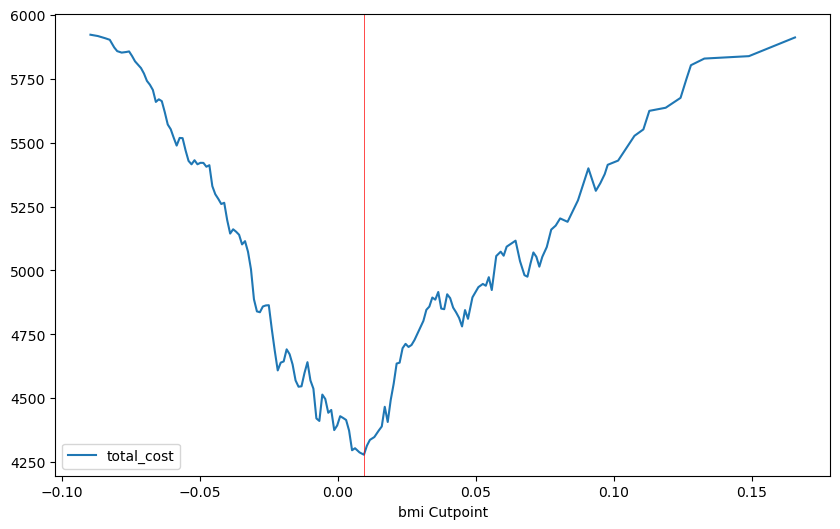

In [11]:
for feat in root_total_cost_by_feature.keys():
    ax = root_total_cost_by_feature[feat]['data'].plot(x= f'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= root_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_xlabel(f'{feat} Cutpoint')

### Root node cutpoint
* Plot Target value versus feature value (blue)
* Black line was initial root node cutpoint
* If the tree was only depth of one, the values predicted would the red dashed lines between the vertical line and data bounds

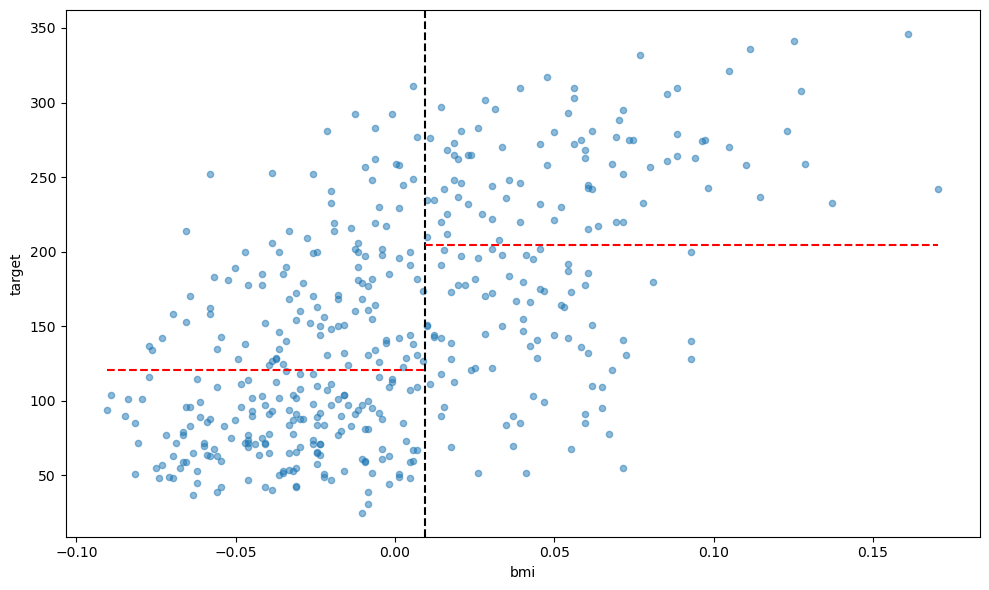

In [12]:
fig, ax = plt.subplots(figsize= (10, 6))
df_1feature.plot.scatter(x= feature_interest, y= 'target', ax= ax, zorder= 1, alpha= 0.5)
plt.axvline(x = root_cut, c= 'black', linestyle= '--')
ax.hlines(y = root_left_avg, 
          xmin= df_1feature[feature_interest].min(), 
          xmax= root_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = root_right_avg, 
          xmin= root_cut, 
          xmax= df_1feature[feature_interest].max(), 
          color= 'red', linestyle= '--')
plt.tight_layout()
plt.show()

## Second cut points

### Left Child Node
* Training data frame is filtered to include only those instances that are less than the initial cutpoint

In [13]:
left_feature, left_cut, left_left_avg, left_right_avg, left_total_cost_by_feature = \
find_optimal_cutpoint(df_1feature[df_1feature[feature_interest] < root_cut])

Parent Node MSE: 3812.9896127930765
Left Node MSE: 2452.0527456382
Right Node MSE: 4915.971221301021


### Show left child node total cost and position of optimal cut

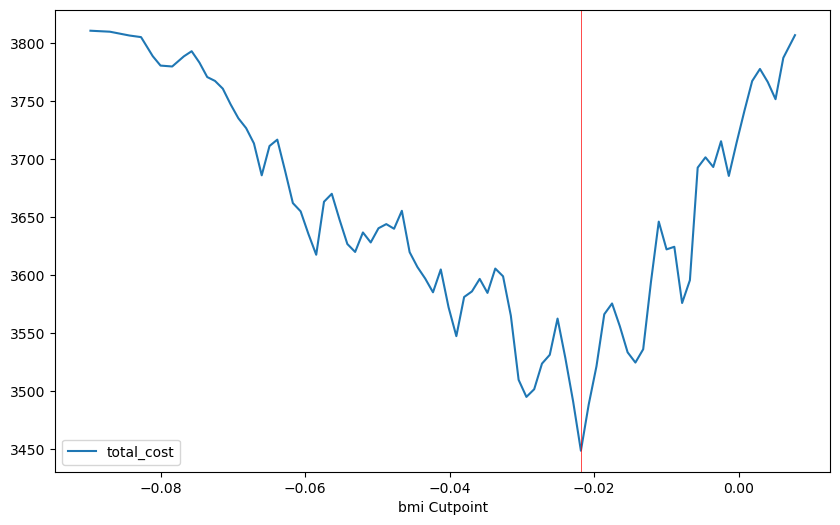

In [14]:
for feat in left_total_cost_by_feature.keys():
    ax = left_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= left_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_xlabel(f'{feat} Cutpoint')

### Right Child Node
* Training data frame is filtered to include only those instances that are equal to, or greater than than the initial cutpoint

In [15]:
right_feature, right_cut, right_left_avg, right_right_avg, right_total_cost_by_feature = \
find_optimal_cutpoint(df_1feature[df_1feature[feature_interest] >= root_cut])

Parent Node MSE: 5061.773957759412
Left Node MSE: 4624.527517146777
Right Node MSE: 2708.5788888888887


### Show right child node total cost and position of optimal cut

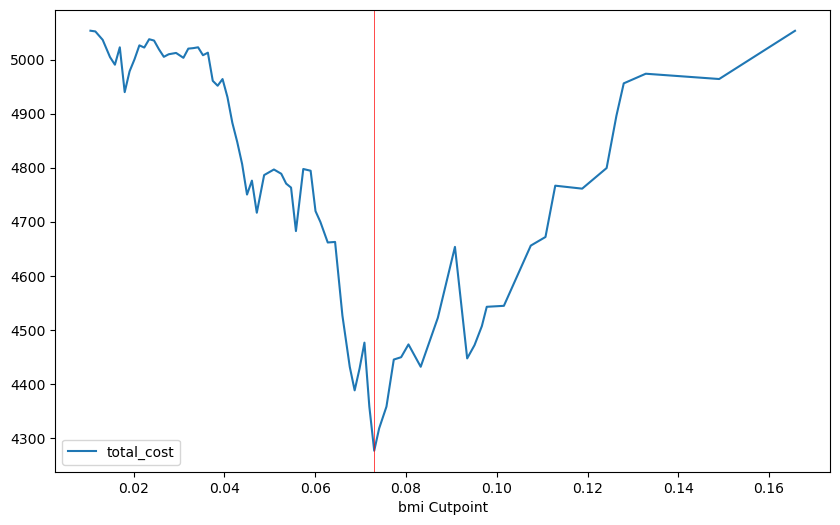

In [16]:
for feat in right_total_cost_by_feature.keys():
    ax = right_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= right_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    ax.set_xlabel(f'{feat} Cutpoint')

### Root node and children node cut points
* Plot Target value versus feature value (blue)
* Verical lines represent best found cutpoints
    * Dotted line was initial root node cutpoint
    * Solid lines are cutpoints found from left and right children nodes
* If the tree was only depth of two, the values predicted would the dashed horizontal line between the verticals or data bounds

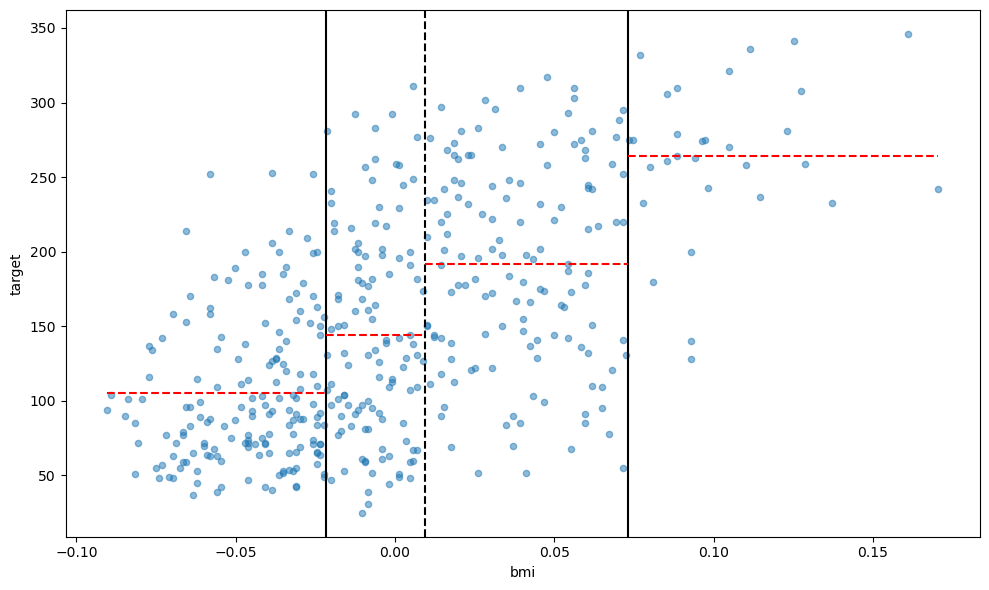

In [17]:
fig, ax = plt.subplots(figsize= (10, 6))
df_1feature.plot.scatter(x= feature_interest, y= 'target', ax= ax, zorder= 1, alpha= 0.5)
plt.axvline(x = root_cut, c= 'black', linestyle= '--')
plt.axvline(x = left_cut, c= 'black')
plt.axvline(x = right_cut, c= 'black')
ax.hlines(y = left_left_avg, xmin= df_1feature[feature_interest].min(), xmax= left_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = left_right_avg, xmin= left_cut, xmax= root_cut, 
          color= 'red', linestyle= '--')
ax.hlines(y = right_left_avg, xmin= root_cut, xmax= right_cut, 
          color= 'red', linestyle= '--',)
ax.hlines(y = right_right_avg, xmin= right_cut, xmax= df_1feature[feature_interest].max(), 
          color= 'red', linestyle= '--')
plt.tight_layout()
plt.show()

### Explicitly calculated cut points

In [18]:
print(root_cut)
print(left_cut)
print(right_cut)

0.009422320935464502
-0.021834229207078688
0.0730132332944317


### Comparison to SKLearn's tree

In [19]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(max_depth= 2)
dec_tree.fit(X= np.array(df_1feature[feature_interest]).reshape(-1, 1), 
             y= df_1feature.target)

sklearn_tree_detail= \
pd.DataFrame({'feature_label':dec_tree.tree_.feature,
              'feature':feature_interest,
              'cutpoint':dec_tree.tree_.threshold
             })


sklearn_tree_detail['feature'] = \
np.where(sklearn_tree_detail.feature_label == -2, 'LEAF', sklearn_tree_detail.feature)
sklearn_tree_detail['cutpoint'] = \
np.where(sklearn_tree_detail.feature_label == -2, np.nan, sklearn_tree_detail.cutpoint)

sklearn_tree_detail

,feature_label,feature,cutpoint
0,0,bmi,0.009422
1,0,bmi,-0.021834
2,-2,LEAF,NaN
3,-2,LEAF,NaN
4,0,bmi,0.073013
5,-2,LEAF,NaN
6,-2,LEAF,NaN


# Construct Regressor with Multiple Features

In [20]:
df.columns

Index(['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6',
       'target'],
      dtype='object')

In [32]:
features_interest = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [33]:
df_multiplefeatures = df[features_interest + ['target']].copy()

In [34]:
root_feature, root_cut, root_left_avg, root_right_avg, root_total_cost_by_feature = \
find_optimal_cutpoint(df_in= df_multiplefeatures)

Parent Node MSE: 5929.884896910383
Left Node MSE: 3240.8209115394334
Right Node MSE: 5135.610889668367


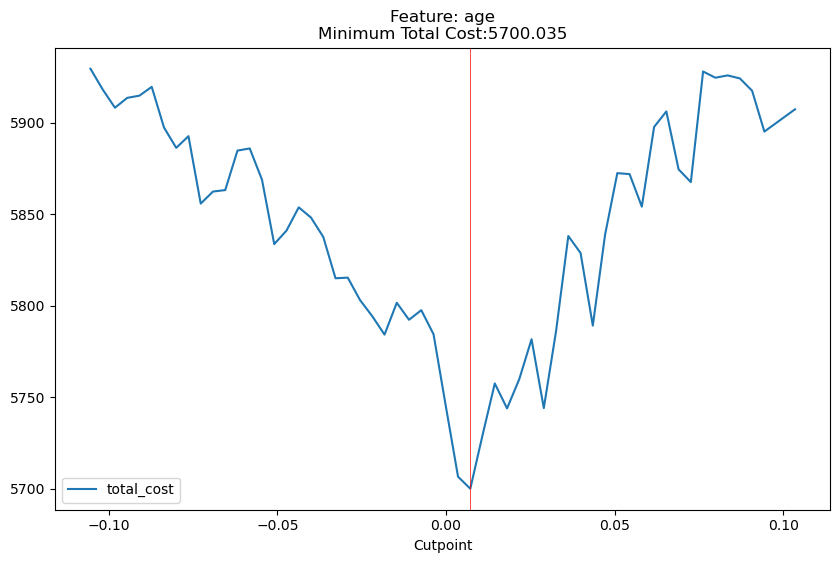

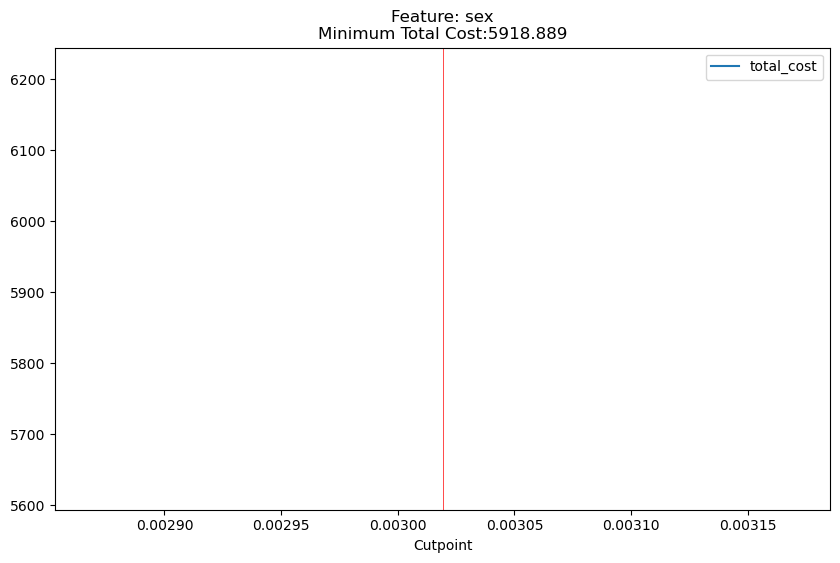

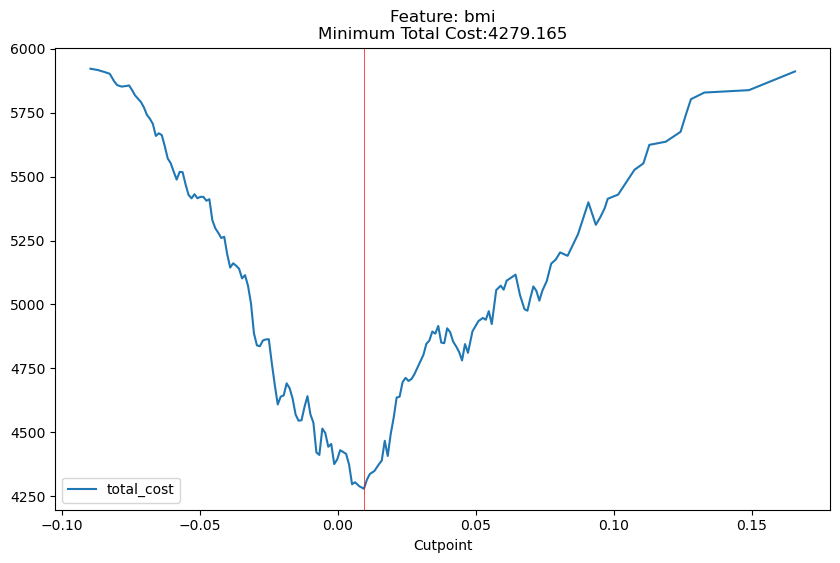

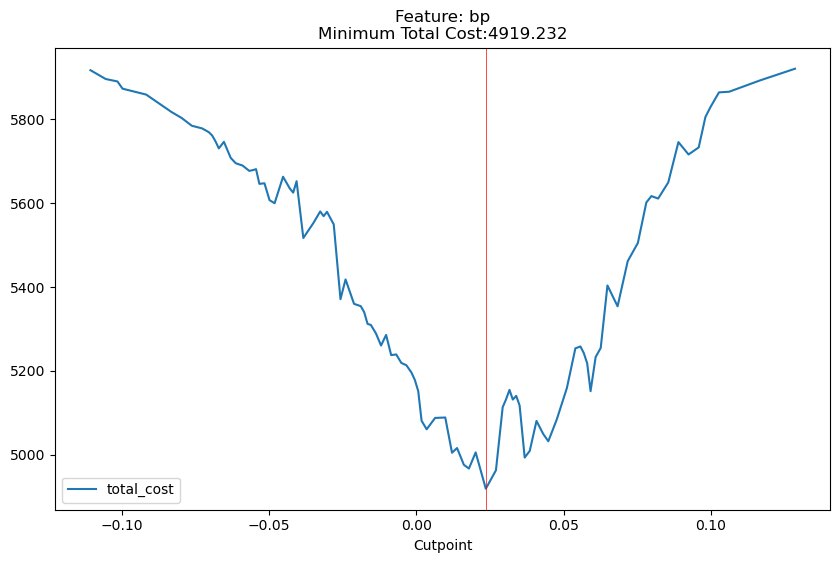

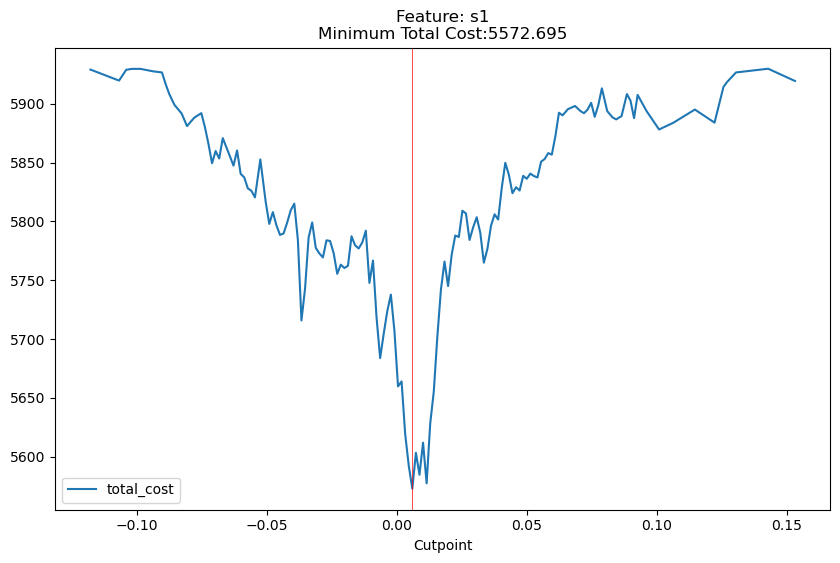

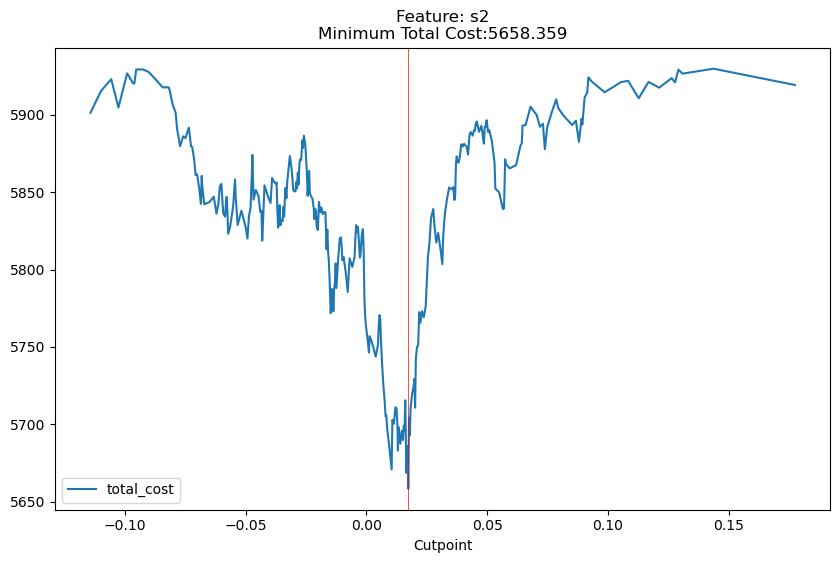

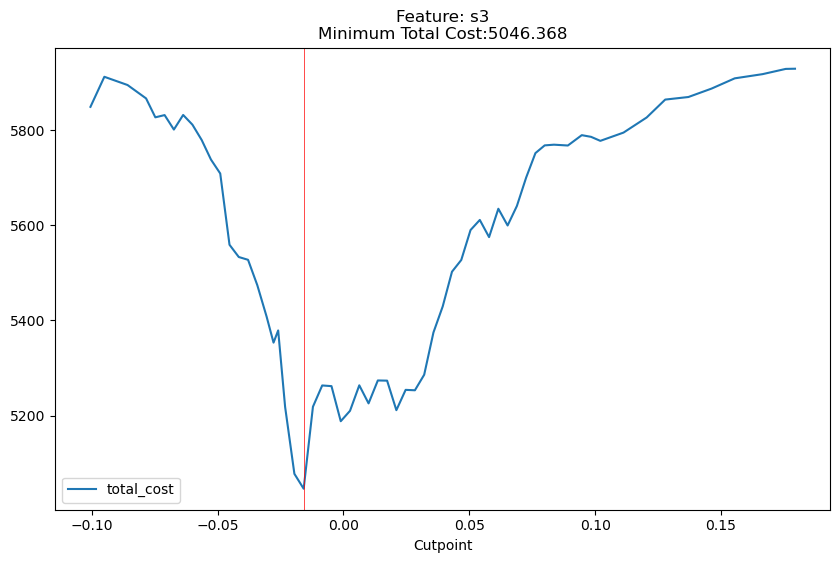

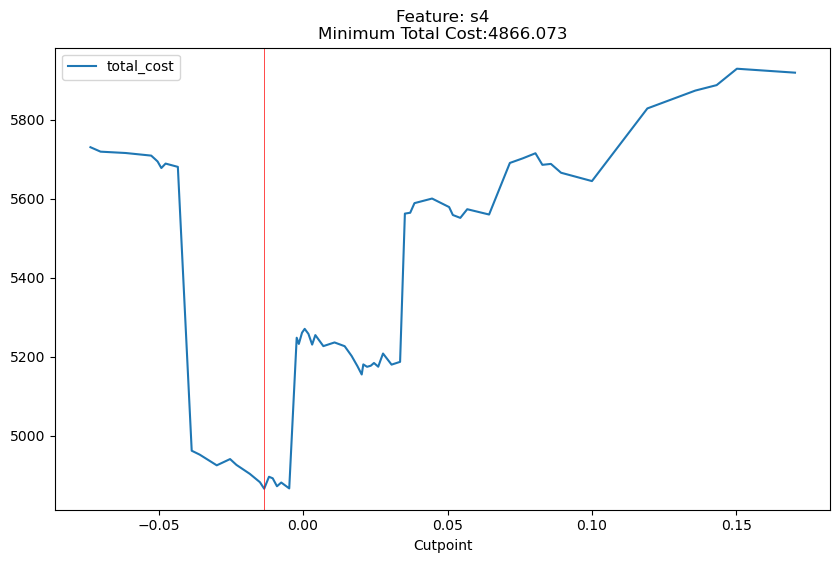

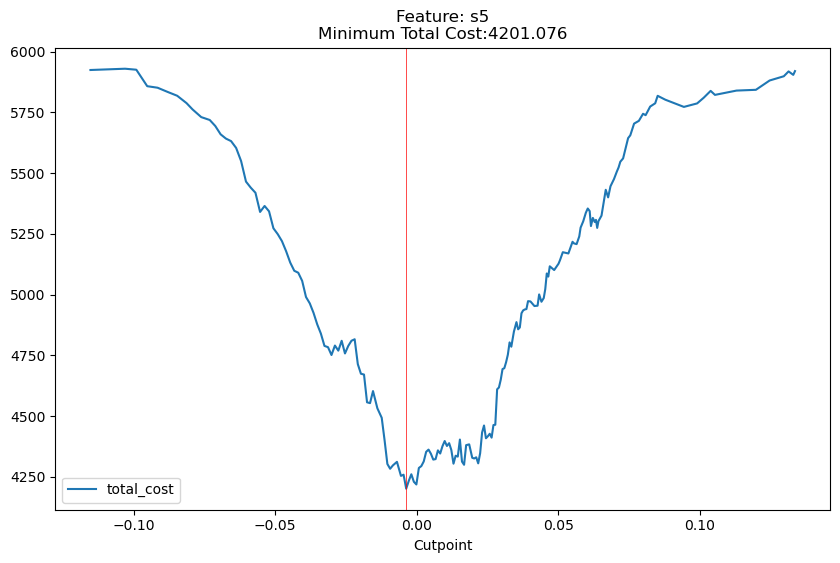

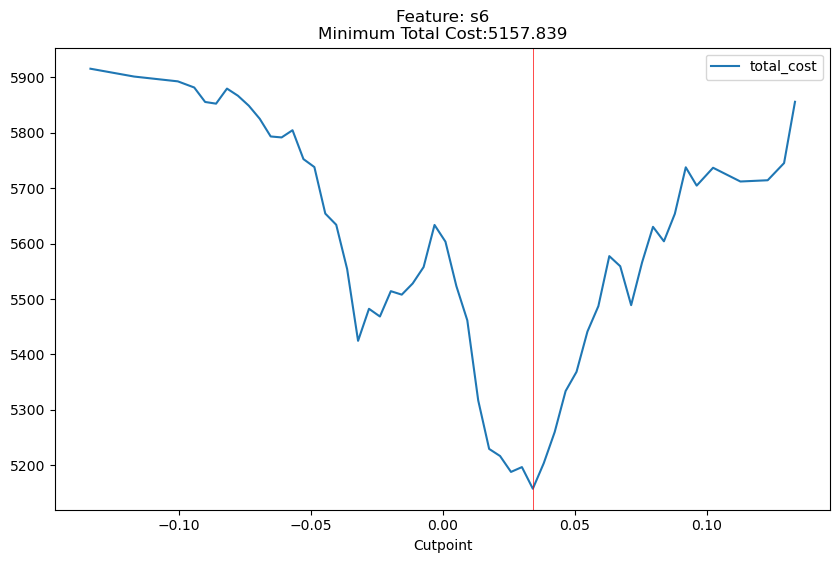

In [35]:
for feat in root_total_cost_by_feature.keys():
    ax = root_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= root_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(root_total_cost_by_feature[feat]["data"].total_cost.min(), 3)
    ax.set_xlabel('Cutpoint')
    ax.set_title(f'Feature: {feat}\nMinimum Total Cost:{best_cost_calculated}')

### Left Node

In [36]:
left_feature, left_cut, left_left_avg, left_right_avg, left_total_cost_by_feature = \
find_optimal_cutpoint(df_multiplefeatures[df_multiplefeatures[root_feature] < root_cut])

Parent Node MSE: 3240.8209115394334
Left Node MSE: 2143.9682637392702
Right Node MSE: 4075.083748302399


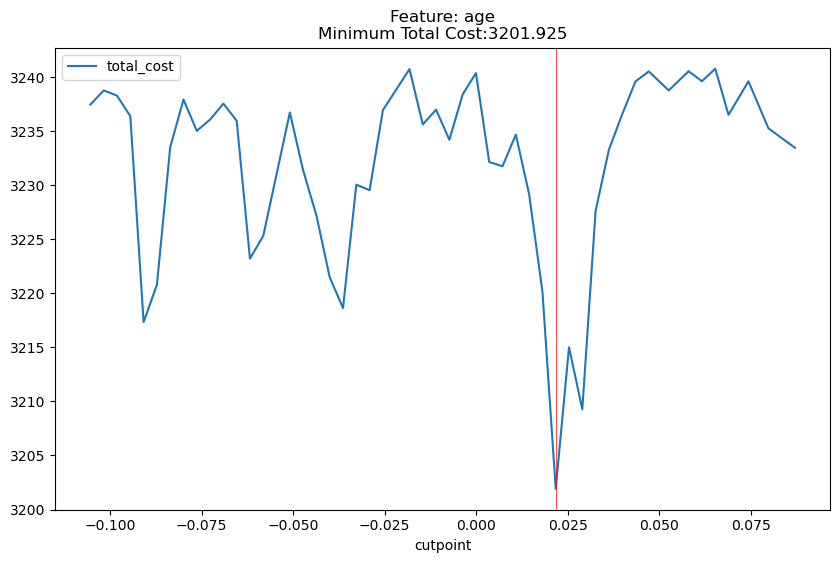

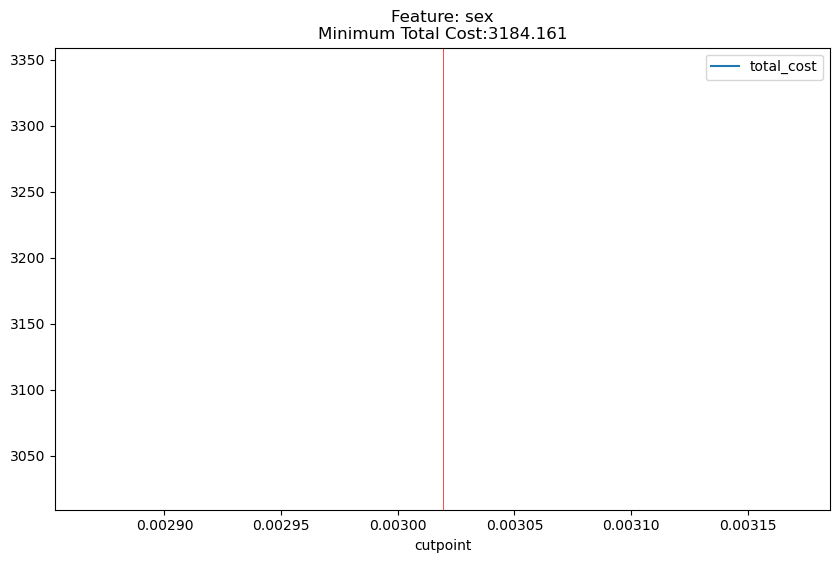

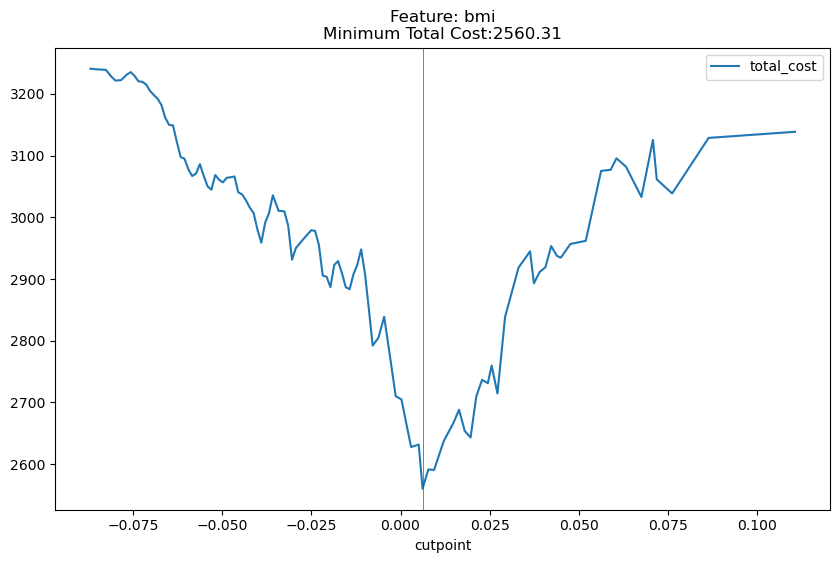

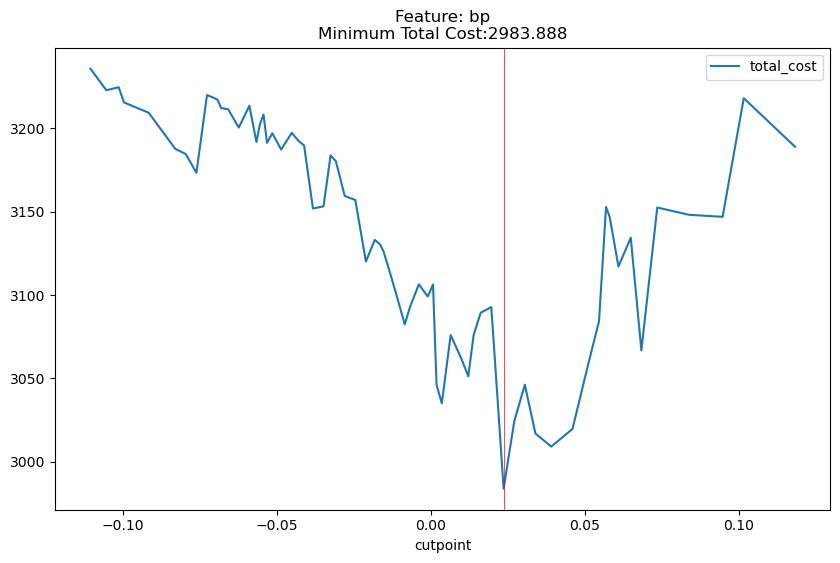

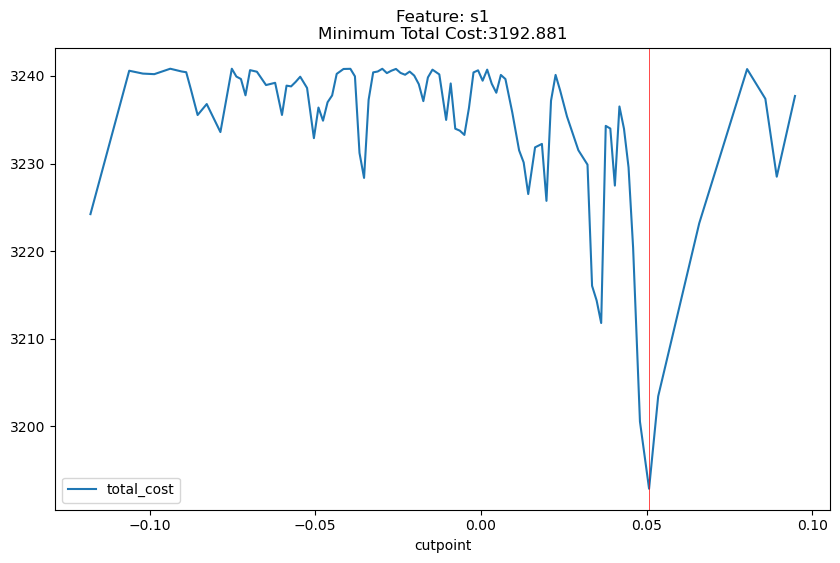

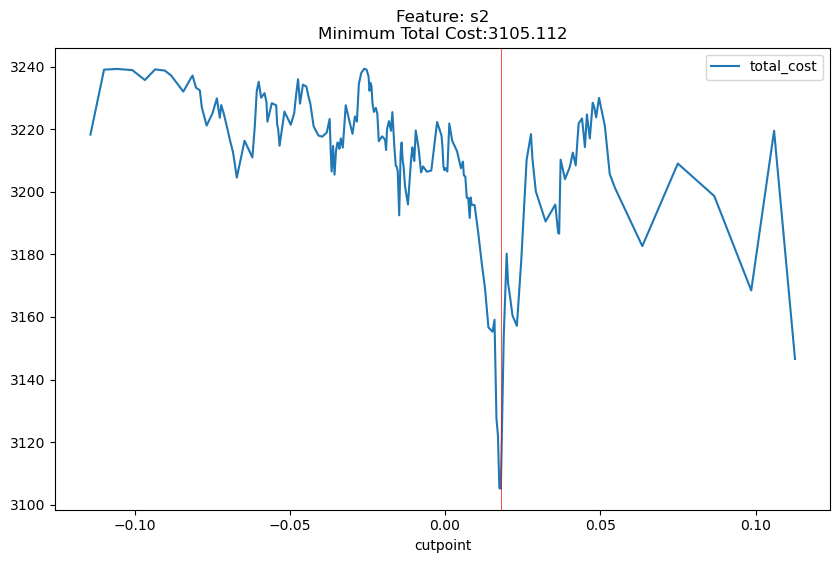

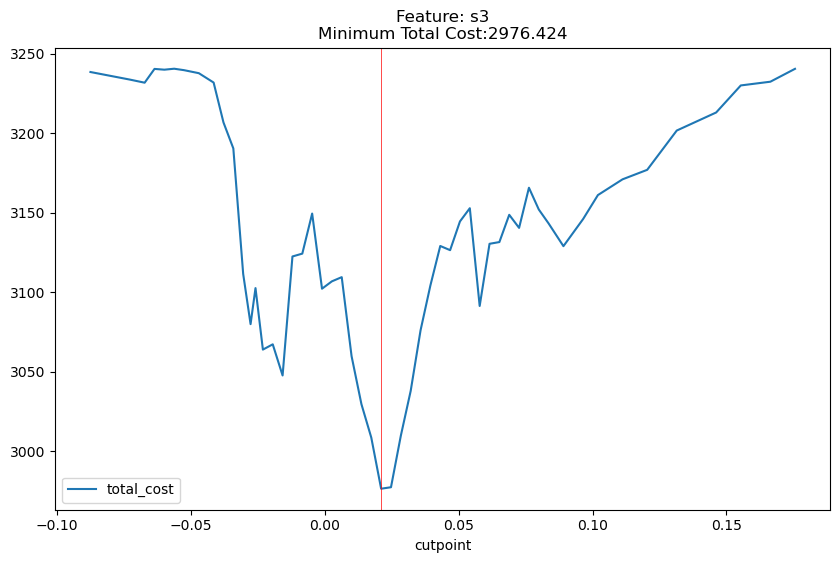

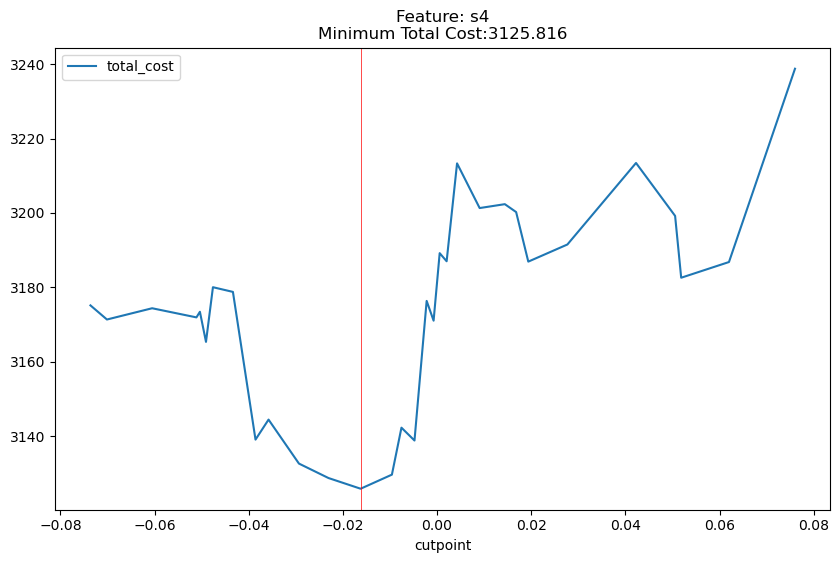

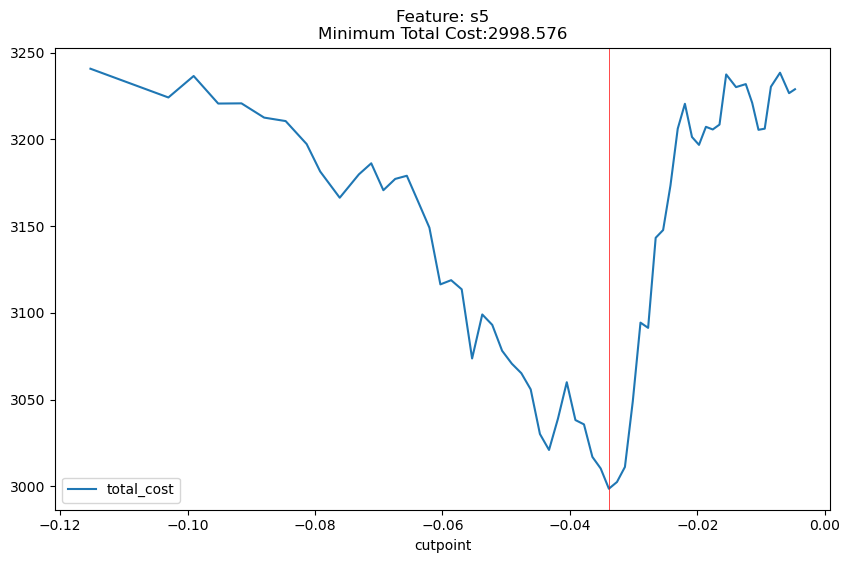

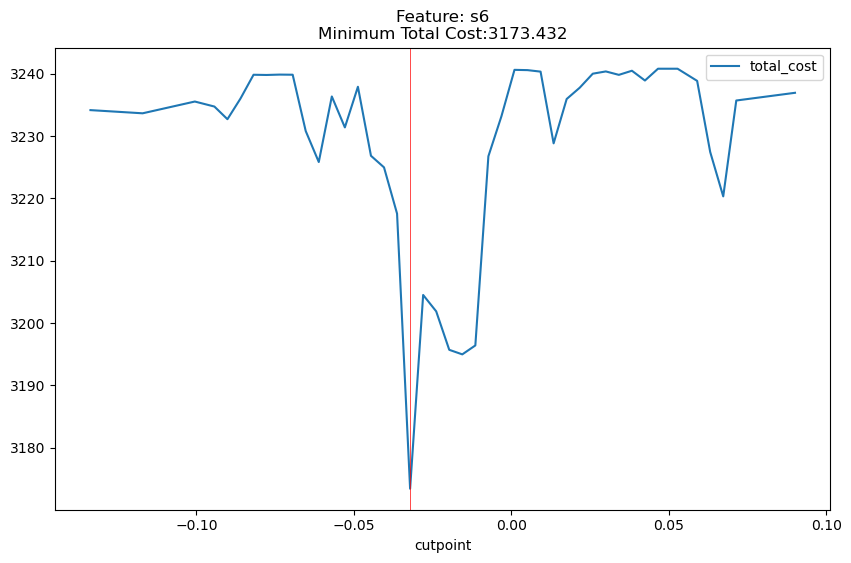

In [37]:
for feat in left_total_cost_by_feature.keys():
    ax = left_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= left_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(left_total_cost_by_feature[feat]["data"].total_cost.min(), 3)
    ax.set_title(f'Feature: {feat}\nMinimum Total Cost:{best_cost_calculated}')

### Right Node

In [38]:
right_feature, right_cut, right_left_avg, right_right_avg, right_total_cost_by_feature = \
find_optimal_cutpoint(df_multiplefeatures[df_multiplefeatures[root_feature] >= root_cut])

Parent Node MSE: 5135.610889668367
Left Node MSE: 4095.8379161712246
Right Node MSE: 4184.050325788751


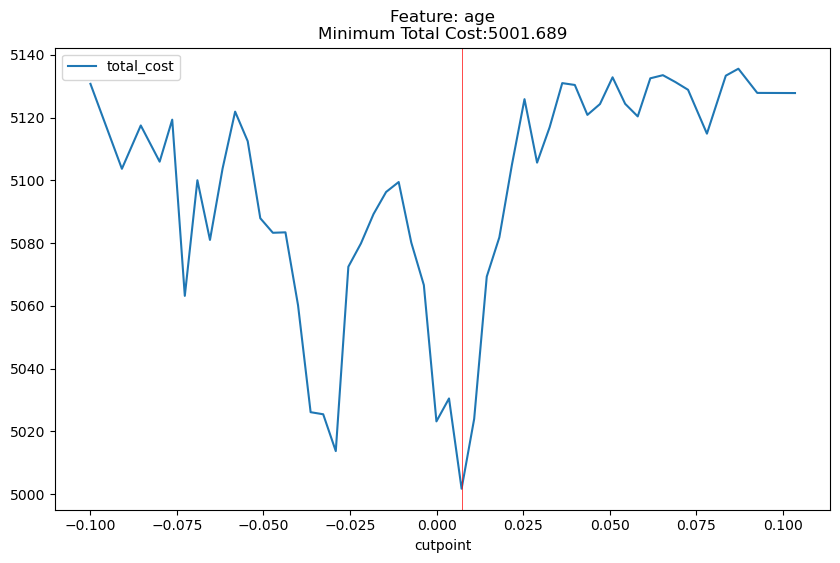

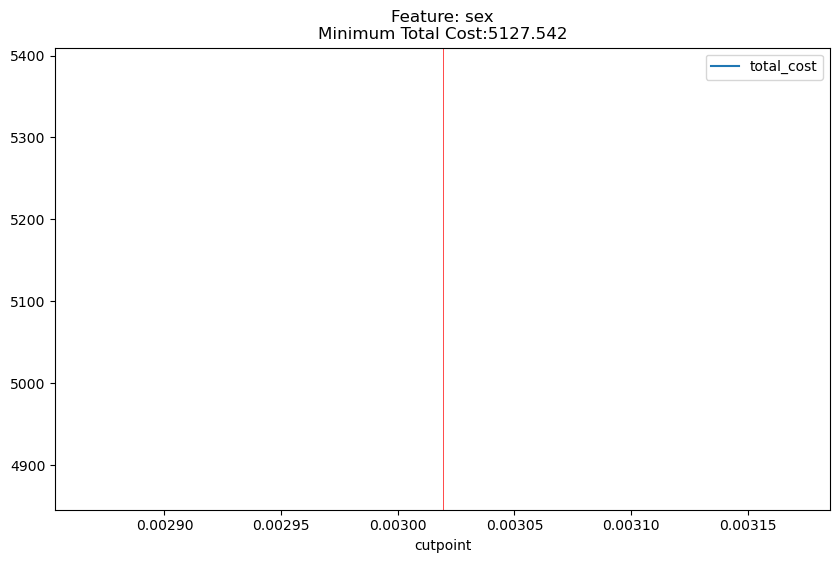

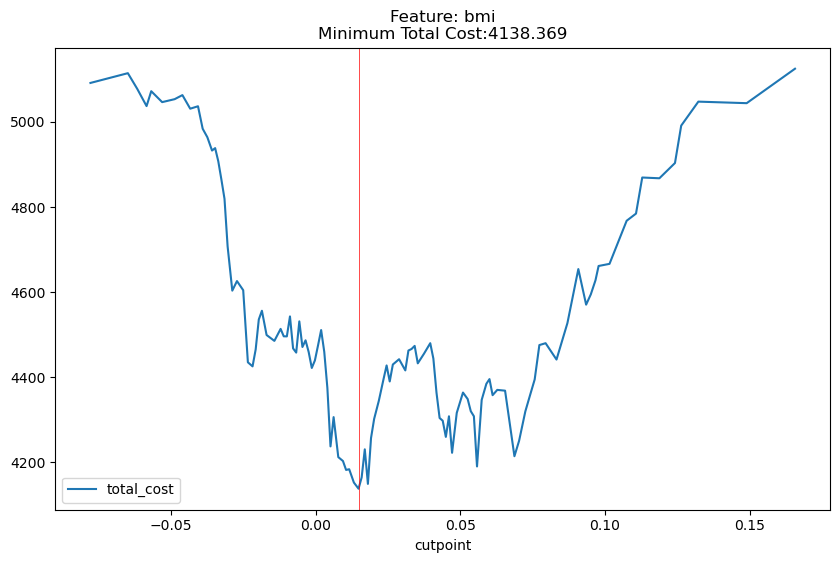

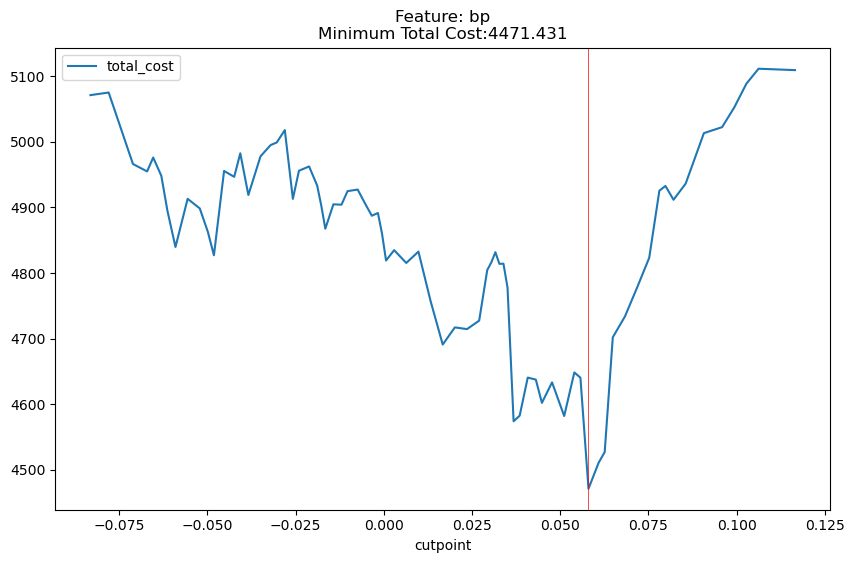

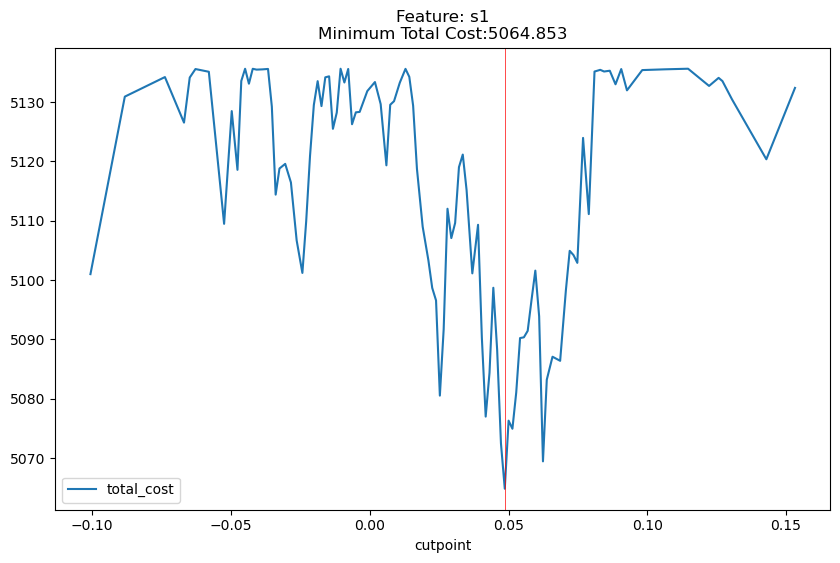

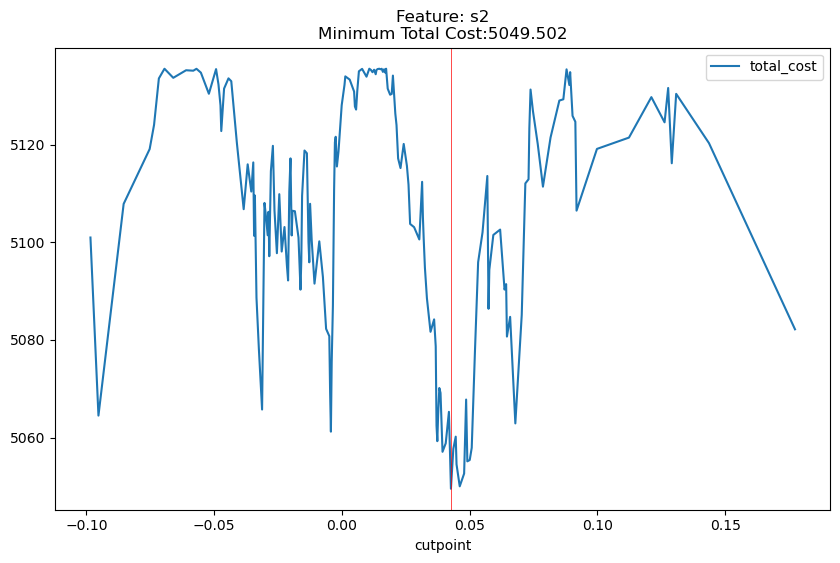

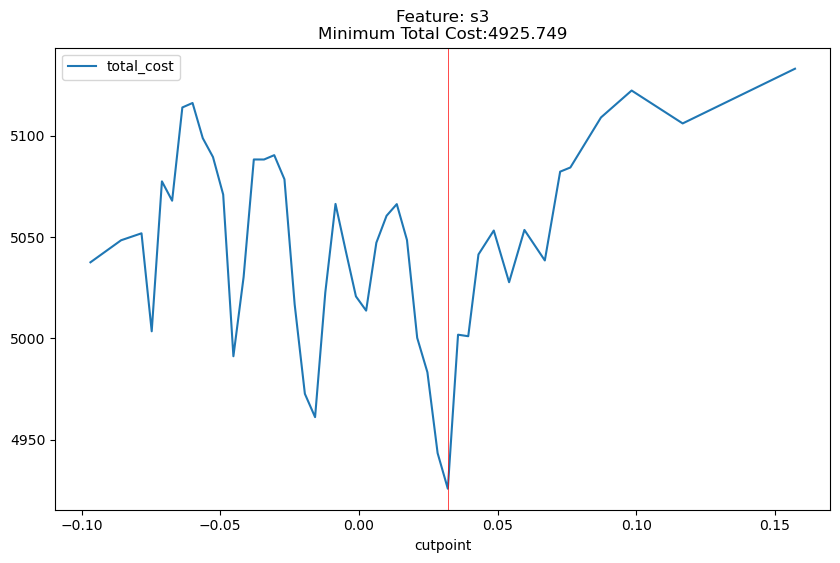

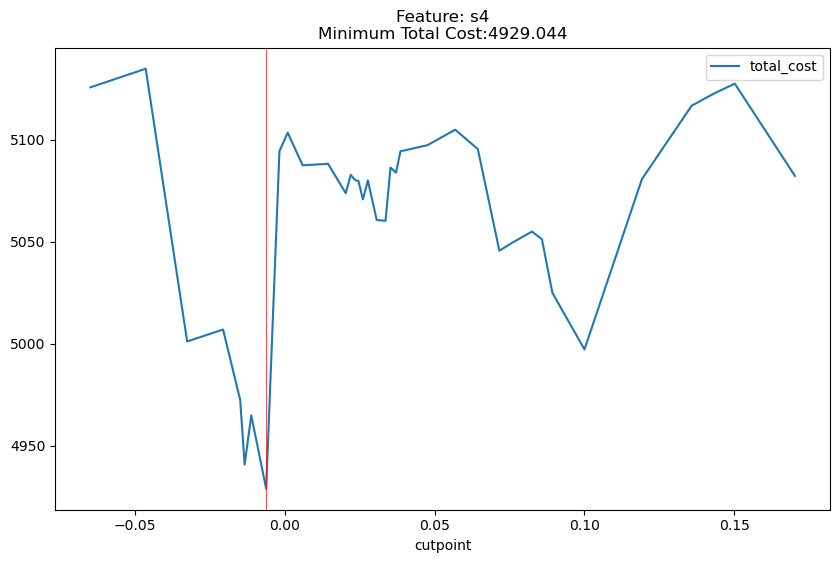

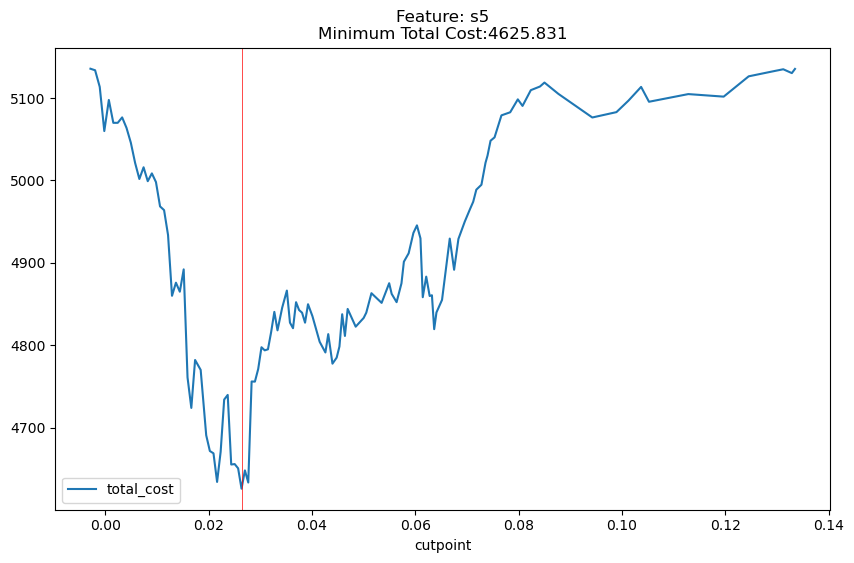

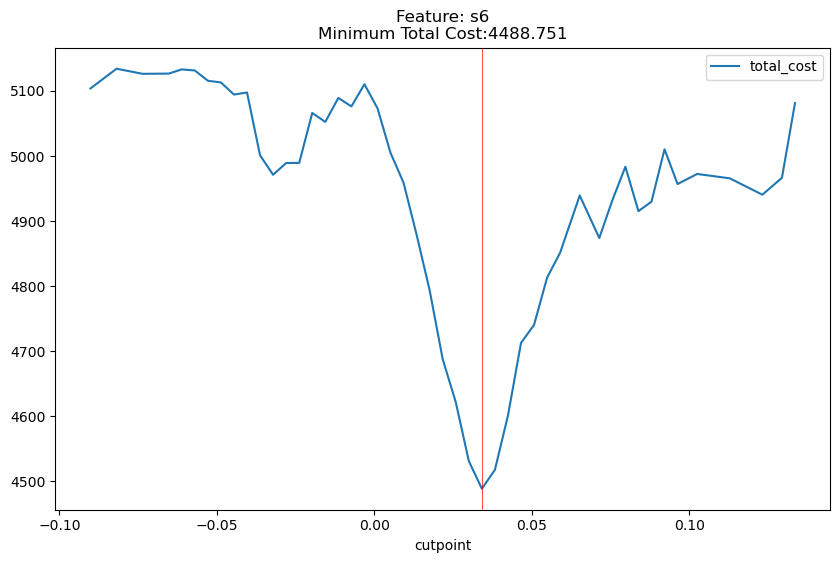

In [39]:
for feat in right_total_cost_by_feature.keys():
    ax = right_total_cost_by_feature[feat]['data'].plot(x= 'cutpoint', y= 'total_cost', figsize= (10, 6))
    ax.axvline(x= right_total_cost_by_feature[feat]['opt_cutpoint'], color= 'r', linewidth= 0.5)
    best_cost_calculated= np.round(right_total_cost_by_feature[feat]["data"].total_cost.min(), 3)
    ax.set_title(f'Feature: {feat}\nMinimum Total Cost:{best_cost_calculated}')

In [40]:
print(root_feature, root_cut)
print(left_feature, left_cut)
print(right_feature, right_cut)

s5 -0.0037611760063045703
bmi 0.0061888847138220964
bmi 0.0148113813048685


In [41]:
from sklearn.tree import DecisionTreeRegressor
dec_tree = DecisionTreeRegressor(max_depth= 2)

dec_tree.fit(X= df_multiplefeatures[features_interest], 
             y= df_multiplefeatures.target)

sklearn_tree_detail= \
pd.DataFrame({'feature_label':dec_tree.tree_.feature,
              'feature':[features_interest[f] for f in dec_tree.tree_.feature],
              'cutpoint':dec_tree.tree_.threshold
             })


sklearn_tree_detail['feature'] = \
np.where(sklearn_tree_detail.feature_label == -2, 'LEAF', sklearn_tree_detail.feature)
sklearn_tree_detail['cutpoint'] = \
np.where(sklearn_tree_detail.feature_label == -2, np.nan, sklearn_tree_detail.cutpoint)

sklearn_tree_detail

,feature_label,feature,cutpoint
0,8,s5,-0.003761
1,2,bmi,0.006189
2,-2,LEAF,NaN
3,-2,LEAF,NaN
4,2,bmi,0.014811
5,-2,LEAF,NaN
6,-2,LEAF,NaN


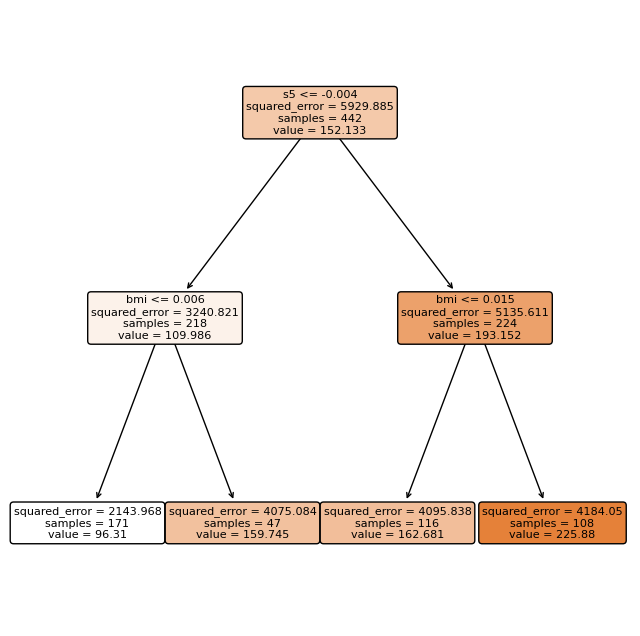

In [42]:
from sklearn import tree

plt.figure(figsize= (8, 8))
tree.plot_tree(decision_tree= dec_tree, 
               feature_names= features_interest,
               rounded= True, filled= True)
plt.show()